In [47]:
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import os
import numpy as np
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
dataset_path  = '/opt/ml/input/data'
path='/opt/ml/input/mmseg/test_check/csv/submission_last_50_only_tta.csv'
test_path = dataset_path + '/test.json'
batch_size=16
result=pd.read_csv(path)
result.iloc[16]

image_id                                         batch_01_vt/0216.jpg
PredictionString    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Name: 16, dtype: object

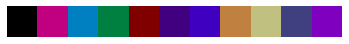

In [42]:
palette = [[0,0,0],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192]]
rgb_list = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
one_px = np.array(palette)[np.newaxis, :, :]
import matplotlib.pyplot as plt
plt.imshow(np.array(one_px))
plt.axis('off')
plt.show()


In [48]:
category_names=['Backgroud', #검정
 'General trash', #핑크
 'Paper', # 하늘
 'Paper pack', # 초록
 'Metal', # 빨강
 'Glass', # 진보라
 'Plastic', # 연남색
 'Styrofoam', # 주황
 'Plastic bag', # 노랑
 'Battery', # 진남색
 'Clothing'] # 연보라

palette = [[0,0,0],[192,0,128],[0,128,192],[0,128,64],[128,0,0],[64,0,128],[64,0,192],[192,128,64],[192,192,128],[64,64,128],[128,0,192]]

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        # image_id = self.coco.getImgIds(imgIds=index)
        image_id = self.coco.getImgIds()[index]
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                print(anns[i]['category_id'])
                print(cats)
                className = get_classname(anns[i]['category_id'], cats)
                print(className)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [49]:
def collate_fn(batch):
    return tuple(zip(*batch))


test_transform = A.Compose([
                           ToTensorV2()
                           ])
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [52]:
# images 제거

import os.path as osp
from glob import glob
data_dir='/opt/ml/input/mmseg/test_check/last_image'
os.makedirs('/opt/ml/input/mmseg/test_check',exist_ok=True)
os.makedirs(data_dir,exist_ok=True)
image_paths = {x for x in glob(osp.join(data_dir, '*'))}

for image_path in image_paths:
    os.remove(image_path)

In [51]:
# images 생성

from PIL import Image
import numpy as np

for i,imgs in enumerate(test_loader):
    temp_images = imgs[0]
    temp_anns = imgs[1]
    for j in range(len(temp_anns)):
        x=torch.Tensor(temp_images[j]).permute([1,2,0])*255
        x=x.numpy().astype(np.uint8)

        y=result['PredictionString'][i*batch_size+j].split(" ")
        for k in range(len(y)):
            y[k]=palette[int(y[k])]
        y=torch.Tensor(y).reshape(512,512,3).numpy()
        temp_result=np.concatenate((x,y),1)
        temp_result=Image.fromarray(temp_result.astype(np.uint8))
        temp_result.save(os.path.join(data_dir,f"{int(temp_anns[j]['id']):04}.jpg"))

KeyboardInterrupt: 